In [7]:
from IPython.core.display import Image

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

In [17]:
def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date, api_key='2gwP5WpwYPiHshKy1H9v')\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date', 'symbol'])
        out = pd.concat([out, df], axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'], data_source='quandl', begin_date='2012-01-01',end_date=None)

In [18]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1) # next day's returns
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5) # next week's returns
outcomes['close_10'] = prices.groupby(level='symbol').close.pct_change(-10) # next two weeks' returns
outcomes['close_20'] = prices.groupby(level='symbol').close.pct_change(-20) # next month's (approx) returns

print(outcomes.tail())

                    close_1  close_5  close_10  close_20
date       symbol                                       
2018-03-23 CSCO   -0.037222      NaN       NaN       NaN
2018-03-26 AAPL    0.026316      NaN       NaN       NaN
           CSCO    0.032334      NaN       NaN       NaN
2018-03-27 AAPL         NaN      NaN       NaN       NaN
           CSCO         NaN      NaN       NaN       NaN


In [19]:
num_obs = prices.close.count()
factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
outcome = 1.*factor_1 + 2.*factor_2 + 3.*factor_3 + 5.*np.random.randn(num_obs)
outcome.name = 'outcome'
print(outcome.tail())

date        symbol
2018-03-23  CSCO      3.323461
2018-03-26  AAPL     -2.754230
            CSCO     -7.123004
2018-03-27  AAPL      5.698239
            CSCO      0.231223
Name: outcome, dtype: float64


In [20]:
features = pd.DataFrame(index=outcomes.index)
features['f11'] = 0.2*factor_1 + 0.8*np.random.randn(num_obs)
features['f12'] = 0.4*factor_1 + 0.6*np.random.randn(num_obs)
features['f13'] = 0.6*factor_1 + 0.4*np.random.randn(num_obs)

features['f21'] = 0.2*factor_2 + 0.8*np.random.randn(num_obs)
features['f22'] = 0.4*factor_2 + 0.8*np.random.randn(num_obs)
features['f23'] = 0.6*factor_2 + 0.4*np.random.randn(num_obs)

features['f31'] = 0.2*factor_3 + 0.8*np.random.randn(num_obs)
features['f32'] = 0.4*factor_3 + 0.6*np.random.randn(num_obs)
features['f33'] = 0.6*factor_3 + 0.4*np.random.randn(num_obs)

features['f41'] = 0.2*factor_1+0.2*factor_2 + 0.6*np.random.randn(num_obs)
features['f42'] = 0.2*factor_2+0.2*factor_3 + 0.6*np.random.randn(num_obs)
features['f43'] = 0.2*factor_3+0.2*factor_1 + 0.6*np.random.randn(num_obs)

features['f51'] = np.random.randn(num_obs)
features['f52'] = np.random.randn(num_obs)
features['f53'] = np.random.randn(num_obs)

print(features.tail())

                        f11       f12       f13       f21       f22       f23  \
date       symbol                                                               
2018-03-23 CSCO    0.191048  0.089119  0.348748 -0.928969  0.212507  0.056624   
2018-03-26 AAPL    0.408702 -0.687440 -0.636561  0.458061  0.056732 -0.125759   
           CSCO    0.758112 -1.175853 -1.572128 -0.122104 -0.385015  0.354216   
2018-03-27 AAPL    0.557021 -1.018523 -0.446960  0.933802  2.763326  3.604543   
           CSCO   -1.892316 -0.099941 -0.646854 -0.145525 -1.582205 -0.629595   

                        f31       f32       f33       f41       f42       f43  \
date       symbol                                                               
2018-03-23 CSCO    0.344708 -0.070712  0.522608  0.119625 -0.295920 -0.012318   
2018-03-26 AAPL   -0.135690 -0.485315 -1.112218 -0.636231 -0.563677 -0.752239   
           CSCO   -0.594335 -0.236062 -0.880716  0.387861  0.974344 -0.543489   
2018-03-27 AAPL    0.924188

In [21]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print(features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())

(3133, 15)
                    outcome
date       symbol          
2018-03-23 CSCO    0.546197
2018-03-26 AAPL   -0.422754
           CSCO   -1.119257
2018-03-27 AAPL    0.924802
           CSCO    0.053209


In [22]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print(features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())

(3133, 15)
                    outcome
date       symbol          
2018-03-23 CSCO    0.546197
2018-03-26 AAPL   -0.422754
           CSCO   -1.119257
2018-03-27 AAPL    0.924802
           CSCO    0.053209


<AxesSubplot:title={'center':'Strength of Correlation'}>

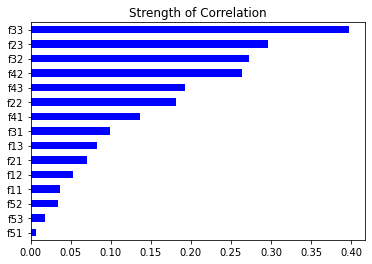

In [23]:
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

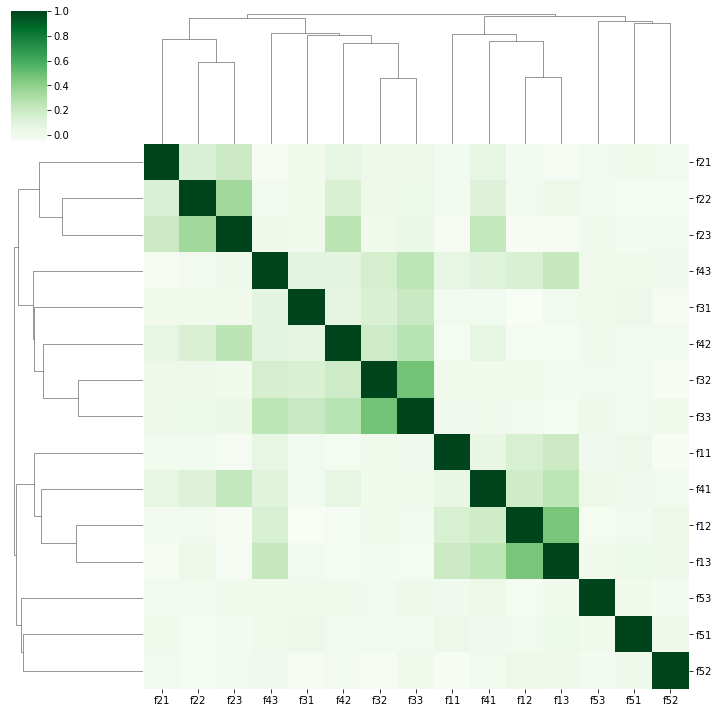

In [24]:
corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [25]:
corr

f11    0.036116
f12    0.052674
f13    0.083236
f21    0.070129
f22    0.180931
f23    0.295948
f31    0.099657
f32    0.272038
f33    0.397808
f41    0.136003
f42    0.264386
f43    0.192451
f51    0.006993
f52    0.033767
f53    0.017736
dtype: float64

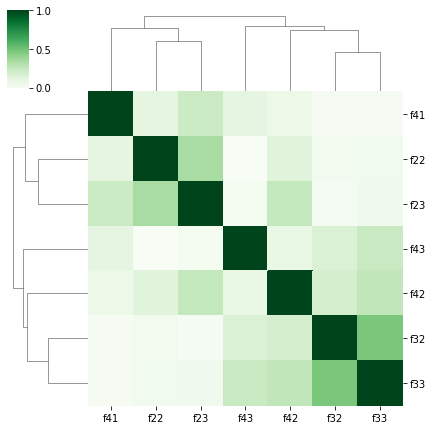

Correlation Strength:
f33    0.397808
f23    0.295948
f32    0.272038
f42    0.264386
f43    0.192451
f22    0.180931
f41    0.136003
dtype: float64


In [26]:
correlated_features = corr[corr>0.1].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


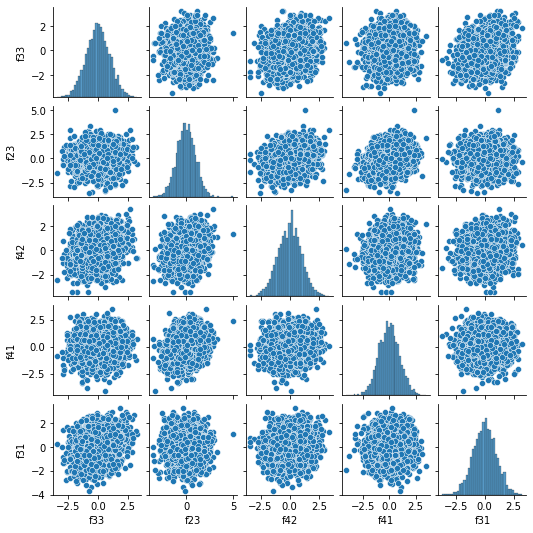

In [27]:
selected_features = ['f33','f23','f42','f41','f31']
import seaborn as sns
sns.pairplot(df[selected_features],size=1.5)

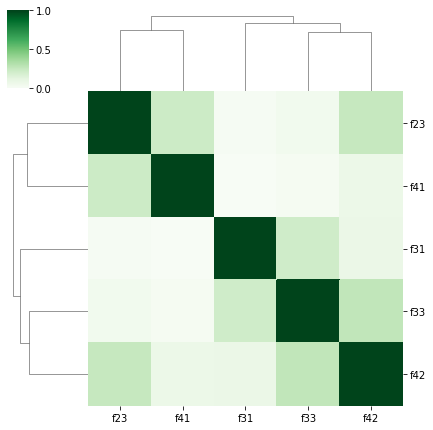

In [28]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [31]:
tmp = df[selected_features].join(outcome_scaled).reset_index().set_index('date')
tmp.dropna().resample('Q').apply(lambda x: x.corr()).iloc[:,-1].unstack()\
.iloc[:, :-1].plot(title='Correlation of Features to Outcome\n (by quarter)')
# shows time stability

TypeError: corr() missing 1 required positional argument: 'other'